In [ ]:
# 官方Repo: https://github.com/facebookresearch/detr.git

# 修改: 將num_classes加到args參數輸入
!git clone https://github.com/taipingeric/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 284 (delta 5), reused 15 (delta 5), pack-reused 265
Receiving objects: 100% (284/284), 12.86 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (147/147), done.


#### Dataset: BCCD

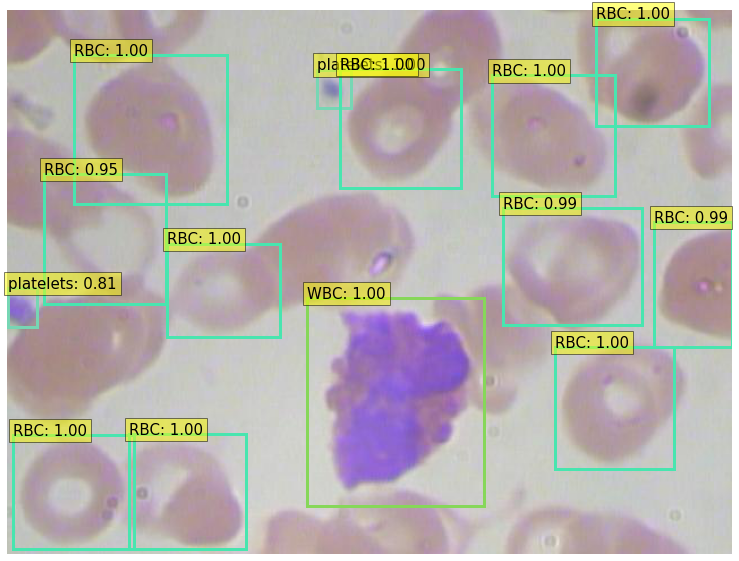

In [ ]:
# !pip install gdown
# 下載資料集
!gdown --fuzzy https://drive.google.com/file/d/196QGZ1gffp6OH0qLCWDJpgCkEzUkSOmk/view?usp=sharing -O bccd.zip

Downloading...
From: https://drive.google.com/uc?id=196QGZ1gffp6OH0qLCWDJpgCkEzUkSOmk
To: /content/bccd.zip
100% 7.99M/7.99M [00:00<00:00, 54.8MB/s]


In [ ]:
# 解壓縮資料集
!mkdir bccd
!unzip -q bccd.zip -d bccd

資料集格式 (COCO)

*   BCCD.v3-raw.coco
    * annotations
        * instances_train2017.json
        * instances_val2017.json
    * train2017
        * img1.jpg
    * val2017
        * img2.jpg
    * test2017
        * img3.jpg



#### Modified pre-trained weights

DETR model zoo: https://github.com/facebookresearch/detr#model-zoohttps://github.com/facebookresearch/detr#model-zoo

雖然Dilated conv.版本的模型較好，但記憶體用量過大(2x) 這邊採用基本conv的 ResNet50 backbone model

1. 讀官方參數檔
2. 剪掉最後一層的參數
3. 存成另一個新的參數檔

In [ ]:
# 切換至 DETR repo
%cd detr

/content/detr


因資料集數量不多，若按照官方只用pre-trained ResNet來訓練DETR，結果會非常差

因此，我們採用整個model都是COCO pre-trained (含Transformer)

但pre-trained model最後一層類別數是COCO的90, 因此將最後一層切掉

想使用其他版本的DETR pre-trained model可到[Official Model Zoo](https://github.com/facebookresearch/detr#model-zoo)

In [ ]:
# 從Facebook 下載pre-trained model

# DETR resnet 50 backbone and head
!wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
# DETR resnet 101 backbone and head
# !wget https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth

import torch
# 1. load the weights, 
# 2. clip out the two layers we want to train, and then save it back out:
checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
torch.save(checkpoint, "detr-r50_ready_to_train.pth")

--2022-07-16 01:40:29--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158.90M  11.7MB/s    in 13s     

2022-07-16 01:40:43 (12.4 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



### Training

* --coco_path: "../bccd/BCCD.v3-raw.coco" 

    data_set路徑
--dataset_file: "custom" 
    
    dataset名稱，官方原本只支援 "coco" & "coco_panoptic"
--num_classes: 4 

    標註類別id最大值+1(no obj)
--resume: "detr-r50_ready_to_train.pth" 

    pre-trained weight路徑, 接續訓練
--output_dir: "./logdir" 

    參數暫存與紀錄
    
**其餘參數請參考官方 main.py**

Single GPU training

In [ ]:
!python main.py --coco_path "../bccd/BCCD.v3-raw.coco" --dataset_file "custom" --num_classes 4 --resume "detr-r50_ready_to_train.pth" --output_dir "./logdir"

Not using distributed mode
git:
  sha: 2121c0ecf70f678ad1a22ea61576160fb4f26a0a, status: clean, branch: main

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='../bccd/BCCD.v3-raw.coco', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=4, num_queries=100, num_workers=2, output_dir='./logdir', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_ready_to_train.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
---> num_classes = 4
for dataset:  custom
/usr/local/lib/python3.7/dist-packages/torchvision/m

Multi-GPU training

* --nproc_per_node=4 GPU數量

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=4 --use_env main.py --coco_path "../bccd/BCCD.v3-raw.coco" --dataset_file "custom" --num_classes 4 --resume "detr-r50_ready_to_train.pth" --output_dir "logdir"

/opt/conda/lib/python3.7/site-packages/torch/distributed/launch.py:164: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  "The module torch.distributed.launch is deprecated "
The module torch.distributed.launch is deprecated and going to be removed in future.Migrate to torch.distributed.run
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
INFO:torch.distributed.launcher.api:Starting elastic_operator with launch configs:
  entrypoint       : main.py
  min_nodes        : 1
  max_nodes        : 1
  nproc_per_node   : 4
  run_id           : none
  rdzv_backend     : static
  rdzv_endpoint    : 127.0.0.1:29500
  rdzv_configs     : {'rank': 0, 'timeout': 900}
  max_restarts     : 3
  monitor_interval : 5
  log_dir          :

### Evaluation

In [ ]:
# Download pretrained weights
!gdown --fuzzy https://drive.google.com/file/d/1Pvu_f9i6bWH8wVtGMmH95pBupPcO8GQ0/view?usp=sharing -O bccd.pth

Downloading...
From: https://drive.google.com/uc?id=1Pvu_f9i6bWH8wVtGMmH95pBupPcO8GQ0
To: /content/detr/bccd.pth
100% 497M/497M [00:02<00:00, 178MB/s]


In [ ]:
!python main.py --batch_size 2 --no_aux_loss --eval --resume "./bccd.pth" --coco_path "../bccd/BCCD.v3-raw.coco" --dataset_file "custom" --num_classes 4

Not using distributed mode
git:
  sha: 2121c0ecf70f678ad1a22ea61576160fb4f26a0a, status: clean, branch: main

Namespace(aux_loss=False, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='../bccd/BCCD.v3-raw.coco', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=True, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=4, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='./bccd.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
---> num_classes = 4
for dataset:  custom
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: User

### Results

300 epochs

```python
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
```

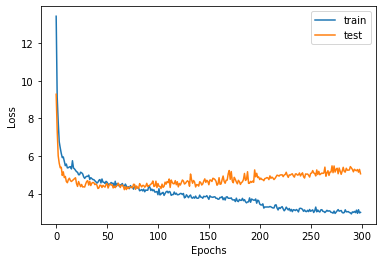

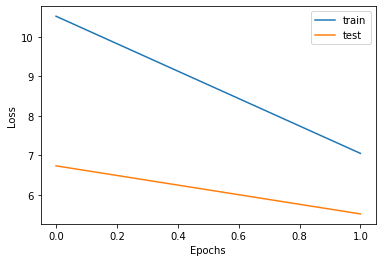

In [ ]:
import matplotlib.pyplot as plt
import json

with open('./logdir/log.txt') as f:
    logs = f.readlines()
    logs = [json.loads(l.replace('\n', '')) for l in logs]
    
plt.plot([log['train_loss'] for log in logs])
plt.plot([log['test_loss'] for log in logs])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'test'])
plt.show()

### Inference

In [ ]:
%cd ..

/content


In [ ]:
import sys
sys.path.append('./detr') # add DETR dir for searching module

import argparse

from detr.main import get_args_parser
from detr.models.detr import DETR
from detr.models.backbone import build_backbone
from detr.models.transformer import build_transformer

In [ ]:
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])

args_dict = {
    '--num_classes': 4,
    '--dataset_file': 'custom',
    '--coco_path': "./bccd/BCCD.v3-raw.coco",
    '--resume': './detr/bccd.pth',
}
args_list = []
for k, v in args_dict.items():
    args_list.append(k)
    args_list.append(str(v))
args_list

# update arguments
args = parser.parse_args(args_list)
print(args)

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='./bccd/BCCD.v3-raw.coco', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=4, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='./detr/bccd.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)


In [ ]:
# 建構模型
backbone = build_backbone(args)
transformer = build_transformer(args)
model = DETR(
    backbone,
    transformer,
    num_classes=args.num_classes,
    num_queries=args.num_queries,
    aux_loss=args.aux_loss,
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 讀取已訓練參數
model.load_state_dict(torch.load('./detr/bccd.pth')['model'])
_ = model.eval()

In [ ]:
import torchvision.transforms as T

# 模型訓練使用前處理 mean-std normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 輸出後處理
# x_c: 中心x座標 (0~1)
# y_c: 中心y座標 (0~1)
# w, h: 預測物件寬高 (0~1)
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# 將box大小轉為原始大小
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def detect(im, model, transform, keep_prob=0.7):
    # mean-std normalize the input image 
    # add batch-size: 1
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)
    # 模型輸出為dict
    
    # pred_logits: N+1類別logits
    # pred_boxes: 物件座標 (x_c, y_c, w, h)
    # aux_outputs: 訓練用, 預測不用
    print(outputs.keys())
    for k, v in outputs.items():
        if k != 'aux_outputs':
            print('key: ', k)
            print('value shape: ', v.shape)
            print('value: ', v[0, :3])
            
    # 預測logits 取softmax, 移除no obj 類別
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    # 計算機率值大於keep_prob的box
    keep = probas.max(-1).values > keep_prob
    # 座標轉換
    # 保留機率值大於keep_prob的box
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [ ]:
from PIL import Image
from glob import glob
import numpy as np

path = np.random.choice(glob('bccd/BCCD.v3-raw.coco/test2017/*.jpg'))
print(path)
img = Image.open(path)

scores, boxes = detect(img, model, transform, 
                       keep_prob=0.7)

# scores (bs, num_queries, num_cls)
# boxes  (bs, num_queries, (x_c y_c w h))

bccd/BCCD.v3-raw.coco/test2017/BloodImage_00359_jpg.rf.56ffe9f91e22e7d456aa886ce6ca117d.jpg


/content/detr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


dict_keys(['pred_logits', 'pred_boxes', 'aux_outputs'])
key:  pred_logits
value shape:  torch.Size([1, 100, 5])
value:  tensor([[-7.5612, -4.9396, -2.1287, -6.4952,  8.0114],
        [-7.9367, -5.5601, -2.4053, -6.9679,  7.7415],
        [-8.1740, -5.8555, -2.2427, -6.6377,  7.4824]],
       grad_fn=<SliceBackward0>)
key:  pred_boxes
value shape:  torch.Size([1, 100, 4])
value:  tensor([[0.0426, 0.4119, 0.0835, 0.2096],
        [0.4147, 0.2150, 0.1512, 0.2253],
        [0.2830, 0.9100, 0.1586, 0.1715]], grad_fn=<SliceBackward0>)


#### Visualization

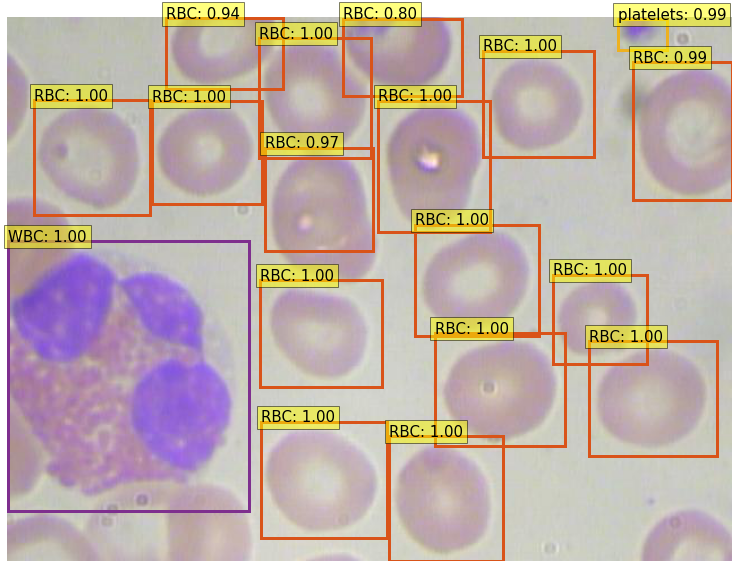

In [ ]:
import matplotlib.pyplot as plt

# 類別名稱
CLASSES = ['N/A', 'platelets', 'RBC', 'WBC']
# 自定義類別顏色
COLORS = [[0.000, 0.447, 0.741],
          [0.929, 0.694, 0.125],
          [0.850, 0.325, 0.098], 
          [0.494, 0.184, 0.556]]
# # 隨機產生顏色
# COLORS = np.random.uniform(size=(len(CLASSES), 3))


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=COLORS[cl], linewidth=3))
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores, boxes)

# Detection - 使用官方 TorchHub 模型


In [ ]:
import numpy as np
import torch

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

In [ ]:
# COCO 類別名稱
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# 隨機顏色
COLORS = np.random.uniform(size=(len(CLASSES), 3))

In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

# 讀取圖片
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im.size

(640, 480)

In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
img.shape

torch.Size([1, 3, 800, 1066])

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, 
                                   color=COLORS[cl], 
                                   linewidth=3))
        
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

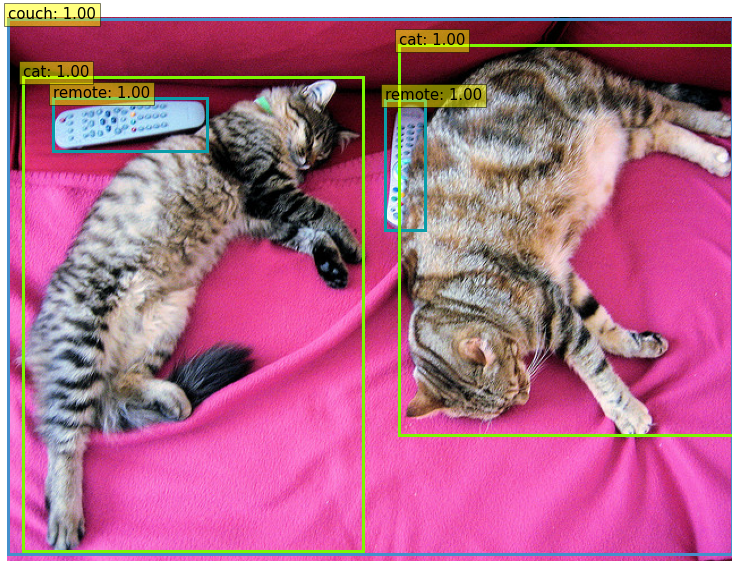

In [ ]:
plot_results(im, probas[keep], bboxes_scaled)

# Detection - 視覺化 encoder-decoder multi-head attention weights
視覺化最後一層Decoder attention weights，觀察偵測每個物件時，關注的區域

使用 forward hook 取出



1. Convolution feature maps
2. Transformer Encoder attention weights
3. Transformer Decoder attention weights 



In [ ]:
# 存放中間層輸出
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# 使用模型預測圖片以得到以hook的內容
outputs = model(img)

for hook in hooks:
    hook.remove()

# 取出feature maps & attention weights
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
print('feature map              (bs, c, h, w)         :', conv_features['0'].tensors.shape) # (bs, c, h, w)
print('encoder attention weight (bs, hw, hw)          :', enc_attn_weights.shape) # (bs, hw, hw)
print('decoder attention weight (bs, num_queries, 850):', dec_attn_weights.shape) # (bs, num_queries, hw)

feature map              (bs, c, h, w)         : torch.Size([1, 2048, 25, 34])
encoder attention weight (bs, hw, hw)          : torch.Size([1, 850, 850])
decoder attention weight (bs, num_queries, 850): torch.Size([1, 100, 850])


視覺化 Decoder attention weights

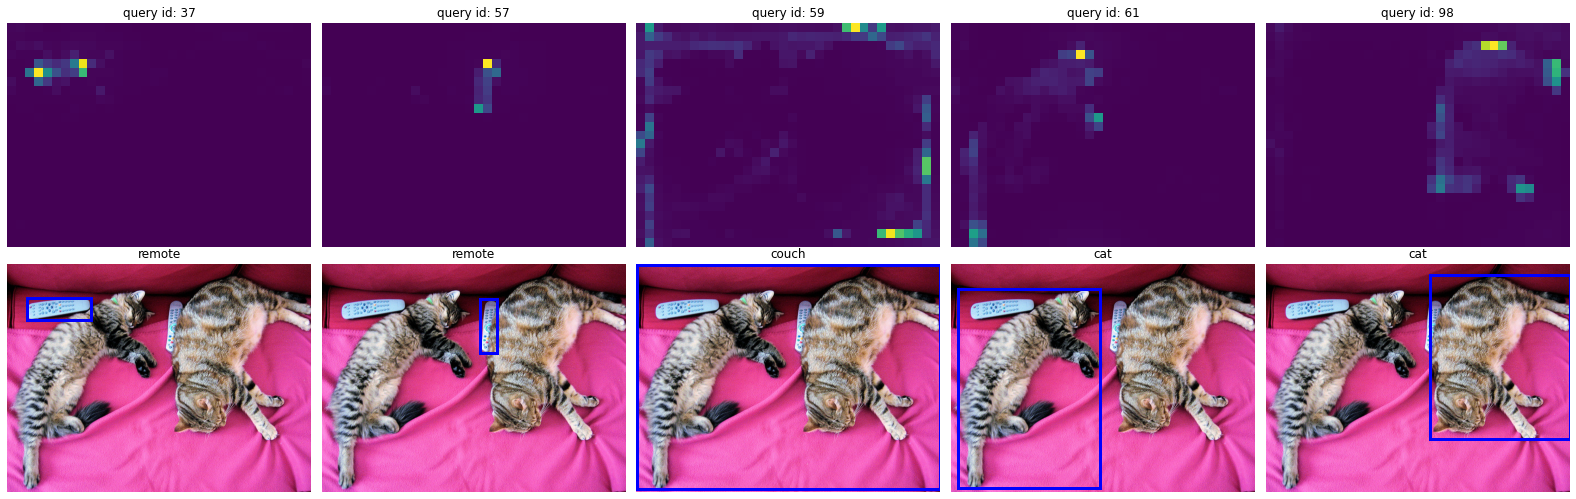

In [ ]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
bboxes_scaled = bboxes_scaled.detach().numpy()
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w).detach().numpy())
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# 視覺化 Encoder attention weights

可以觀察到在encoder attention weights中就已經有物件分離的概念

In [ ]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention: ", enc_attn_weights[0].shape)
print("Feature map:       ", f_map.tensors.shape)

Encoder attention:  torch.Size([850, 850])
Feature map:        torch.Size([1, 2048, 25, 34])


self-attention是個`[H * W, H * W]`的矩陣, `H`和`W`是feature maps大小, reshape成 `[H, W, H, W]`.

In [ ]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# reshape encoder attention weights to (H, W, H, W)
sattn = enc_attn_weights[0].reshape(shape + shape).detach().numpy()
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: (25, 34, 25, 34)


因為矩陣大小非常大，選擇幾個參考點做視覺化

In [ ]:
img.shape

torch.Size([1, 3, 800, 1066])

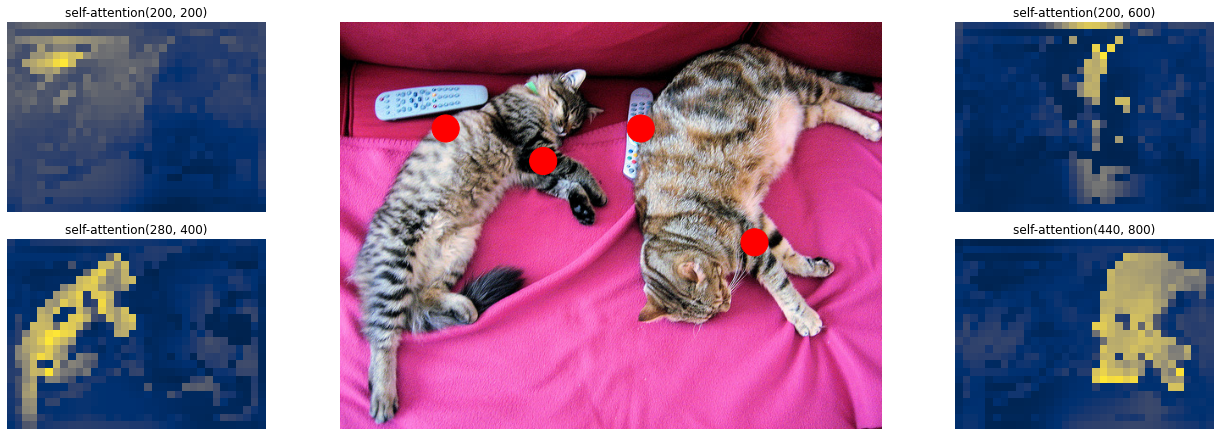

In [ ]:
# CNN縮小倍率 DETR: 32, DETR DC5: 16
fact = 32

# 視覺化4個參考點
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# 每個參考點的attention weights
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact) # 計算參考點對應到的attention weights位置
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest') # 顯示該位置對應的attention weights
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# 中央圖片+參考點
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

可以觀察到在Encoder中，已經有將物件分離出背景的概念

## 互動式 self-attention 視覺化

### Defining the AttentionVisualizer

There is a lot of code in there, but it's mostly boilerplate so that we can have a nice demo.
Ideally, we would have enabled a click-on-the-image to get the point we want to look at, but I couldn't make it work with Colab, so we used sliders instead.

You should execute the cell below, which is hidden in order to keep everything tidy, in order to get the `AttentionVisualizer` class that we will be using afterwards.

In [ ]:
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='http://images.cocodataset.org/val2017/000000039769.jpg',
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # propagate through the model
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        # don't need the list anymore
        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        shape = self.conv_features['0'].tensors.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)
    
    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)
    
    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 8))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)
            
            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]
            sattn_map = sattn_map.detach().numpy()
            axs[1].imshow(sattn_map, cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()
        
    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

### Using the AttentionVisualizer

Ok, phew, that was a lot of code, but how do we use it?
Just run the following cell, and it should work!

You can change the URL in the field, but don't forget to hit ENTER to submit it.
In the same way, we made the sliders only update its value once the user releases it, in order to avoid lags.

We additionally add two options for visualization:
- Direction of self-attention: the self-attention is a `[H, W, H, W]` matrix, so given a `i, j` point, we can return either `[i, j, :, :]` or `[:, :, i, j]`. This flag let's you chose how you want to visualize it
- Show red dot in attention: just adds a red dot to the self-attention image to facilitate visualization.

Give it a try!

In [ ]:
import ipywidgets as widgets
import math
from IPython.display import display, clear_output

w = AttentionVisualizer(model, transform)
w.run()

In [ ]:
# 其他圖片
# https://chieformula.files.wordpress.com/2022/05/top-gun-maverick-ver5-xlg-2-1.jpg
# http://images.cocodataset.org/val2017/000000039769.jpg
# https://pics.filmaffinity.com/Top_Gun_Maverick-733802541-large.jpg

#### main.py 參數參考

In [ ]:
args = {
    '--lr': 1e-4,
    '--lr_backbone': 1e-5,
    '--batch_size': 2,
    '--weight_decay': 1e-4,
    '--epochs': 300,
    '--lr_drop': 200,
    '--clip_max_norm': 0.1,
    '--num_classes': 20,

    # Model parameters
    '--frozen_weights': None,
    # * Backbone
    '--backbone': 'resnet50',
    '--dilation': False,
    '--position_embedding': 'sine',

    # * Transformer
    '--enc_layers': 6,
    '--dec_layers': 6,
    '--dim_feedforward': 2048,
    '--hidden_dim': 256,
    '--dropout': 0.1,
    '--nheads': 8,
    '--num_queries': 100,
    '--pre_norm': False,

    # * Segmentation
    '--masks': False,

    # Loss
    '--no_aux_loss': False,
    # Matcher
    '--set_cost_class': 1,
    '--set_cost_bbox': 5,
    '--set_cost_giou': 2,
    # Loss coefficients
    '--mask_loss_coef': 1,
    '--dice_loss_coef': 1,
    '--bbox_loss_coef': 5,
    '--giou_loss_coef': 2,
    '--eos_coef': 0.1,

    # dataset parameters
    '--dataset_file': 'custom', # the name of your dataset excluding "coco", "coco_panoptic" 
    '--coco_path': "./bccd/BCCD.v3-raw.coco",
    '--coco_panoptic_path': None,
    '--remove_difficult': False,

    '--output_dir': './logdir', # dir of logs and ckpt files
    '--device': 'cuda',
    '--seed': 42,
    '--resume': './detr/logdir/checkpoint.pth', # pretrained weights
    '--start_epoch': 0,
    '--num_workers': 2,
}